In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.mp.linear import LinearExpr
import import_ipynb
import numpy as np
import Methods as mt
%matplotlib inline

In [41]:
#Leitura das Instâncias
veiculos = pd.read_csv("k_30",index_col=0)
vitimas = pd.read_csv("v_10",index_col=0)
pontos = pd.read_csv("n_200",index_col=0)
hospitais = veiculos["Inicial"].unique()

In [42]:
#Criação da Matriz de Distância
_DistanceMatrix = pd.read_csv("d_200",index_col=0)

In [43]:
#Excluimos todas as distâncias referentes
#aos arcos não existentes
for i in _DistanceMatrix.index:
    for j in _DistanceMatrix.index:
        if j not in pontos.loc[i][2:].values:
            _DistanceMatrix.loc[i][j]=0

# Modelagem - VRP

In [44]:
vrp = Model("Ambulancias-VRP") #Modelo

In [45]:
#Matriz com as variáveis de decisão principais
_DecisionCube = vrp.binary_var_cube(_DistanceMatrix.index,_DistanceMatrix.index,veiculos.index,"Arc")

In [46]:
#Função Objetivo
vrp.minimize(vrp.sum(_DecisionCube[i,j,k]*_DistanceMatrix.loc[i][j] 
                     for i in _DistanceMatrix.index 
                     for j in _DistanceMatrix.index 
                     for k in veiculos.index))

In [47]:
forbidden = LinearExpr(vrp)   #Arcos proíbidos

for k in veiculos.index:
    for i in _DistanceMatrix.index:

        flux = LinearExpr(vrp)    #Conservação de Fluxo
        match = LinearExpr(vrp)   #Restrição de Compatibilidade
        for j in _DistanceMatrix.index:

            if _DistanceMatrix.loc[i][j] > 0:    #Verifica se o arco existe

                if i in vitimas["Ponto"].values:   #Se nodo 'i' for uma vítima:
                    match+=_DecisionCube[j,i,k]    #Adiciona os arcos 'jik' em 'match'
                    flux +=_DecisionCube[j,i,k]    #Subtrai o arco de chegada em 'i'
                    forbidden+=_DecisionCube[i,j,k]#A ambulância não pode um arco saindo de 'i'

                elif i == veiculos.loc[k]["Inicial"]: #Se o nodo 'i' for um hospital
                    flux += _DecisionCube[i,j,k]      #Adiciona o arco de saída de 'i'

                elif j == veiculos.loc[k]["Inicial"]: #Se o nodo 'j' for o ponto de saida de 'k'
                    forbidden += _DecisionCube[i,j,k] #Retira o arco 'ij' da solução
                    flux -=_DecisionCube[j,i,k]       #Coloca o arco de saída de 'j' no fluxo

                else:                                 #Se nenhum desses casos se aplicar
                    flux+=_DecisionCube[i,j,k]-_DecisionCube[j,i,k] #Fluxo normal


            else:                                #Se o arco não existir
                forbidden += _DecisionCube[i,j,k]#Tira ele da solução

        if i in vitimas["Ponto"].values: #Se nodo 'i' for uma vítima
            #Permite 'k' chegar em 'i' no máximo 1 vez
            vrp.add_constraint(flux<=1,"ChegadaVitima_"+str(i)+"_Carro_"+str(k))

            #Pega a prioridade da vitima 'i'
            prioridade = vitimas[vitimas["Ponto"] == i]["Prioridade"].values[0]

            #E cria as restriçõe de UpperBound
            vrp.add_constraint((veiculos.loc[k]["UpperBound"])*match-prioridade*match>=0,
                               "MatchUB_Ocurrence_"+str(i)+"_Vehicle"+str(k))
            #E LowerBound
            vrp.add_constraint((veiculos.loc[k]["LowerBound"])*match-prioridade*match<=0,
                              "MatchLB_Ocurrence_"+str(i)+"_Vehicle"+str(k))

        elif i == veiculos.loc[k]["Inicial"]: #Se o nodo 'i' for o inicial do veiculo 'k'
            #Permite 'k' sair de 'i' no máximo 1 vez
            vrp.add_constraint(flux<=1,"FluxoInicialVeiculo_"+str(k))
        else:
            #Fluxo Normal
            vrp.add_constraint(flux==0,"Fluxo_"+str(i)+"_Carro_"+str(k))

#Eliminação dos arcos inválidos
vrp.add_constraint(forbidden==0,"Cuts");

In [48]:
for k in veiculos.index:

    inicial = veiculos.loc[k]["Inicial"] #Ponto de Saída de 'k'

    flux_inicial = LinearExpr(vrp) #Fluxo de Saída de 'k'

    for i in pontos.loc[inicial][2:].values:          #Para todos os arcos saindo do inicial
        flux_inicial+=_DecisionCube[inicial,int(i),k] #Adicione-os ao fluxo de saída

    flux_final = LinearExpr(vrp) #Fluxo de Chegada nas ocorrências

    for i in vitimas["Ponto"].values:          #Para todas as ocorrências
        for j in pontos.loc[i][2:]:            #Para todos os arcos saindo delas
            flux_final += _DecisionCube[j,i,k] #Adicione-os ao fluxo de chegada

    #Se o veículo sair de seu ponto inicial, ele deve atender uma ocorrência
    vrp.add_constraint(flux_inicial-flux_final==0,"AtendimentoObrigatorio_"+str(k))

In [49]:
for i in vitimas["Ponto"].values:

    demand = LinearExpr(vrp) #Demanda da vítima 'i'

    for j in pontos.loc[i][2:].values:
        for k in veiculos.index:
            #Para cada arco 'j' chegando em 'i' e veículo 'k'
            #Os adicionamos à expressão
            demand+=_DecisionCube[int(j),int(i),k]
    #Ao menos um precisa passar nessa vítima
    vrp.add_constraint(demand>=1,"DemandaVitima_"+str(i))


In [50]:
for k in veiculos.index:
    capacidade = LinearExpr(vrp) #Capacidade do veículo 'k'
    for i in vitimas["Ponto"].values:
        for j in pontos.loc[i][2:]:
            #Para cada arco chegando em cada vítima
            #Adicione-o à expressão
            capacidade+=_DecisionCube[int(j),int(i),k]

    #O veículo só pode 
    vrp.add_constraint(capacidade<=1,"CapacidadeVeiculo_"+str(k))

In [51]:
import time
start = time.time() #Tempo de ínicio
subcicle = True     #Condição de parada
#Assumindo que existe subciclos, nós...
while subcicle == True:

    #Rota percorrida por cada veículo
    routes = {x:{} for x in veiculos.index}    

    #Solução VRP - Dicionário Desordenado
    _Solution = vrp.solve(log_output=True).as_dict()
    #saida veículo
    #    |   |
    #    v   v
    #Arc_i_j_k: True/False <-Valores Possíveis
    #      ^
    #      |
    #   chegada
    #
    #Arc_i_j_k = Chave

    for i in _Solution:
        #
        #
        #"Arc_i_j_k"
        #     |   
        #     v                      0   1   2
        aux = i.split("_")[1:] #<- ["i","j","k"]
        #        ^
        #        |
        #["Arc","i","j","k"]
        #
        #         veiculo=k    saida=i      chegada=j
        #             |            |            |
        #             v            v            v
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        # ^
        # |_ Rotas agrupadas por veículo

    print(routes)
    count = 0 #Contador para as eliminações de subciclo
    summ = 0 #Condição de parada

    #O trecho de código abaixo deve remover o caminho
    #principal para futuramente verificarmos se existe
    #algum subciclo na rota do veículo 'k'
    for k in veiculos.index:

        #Primeiramente, verificamos se o veículo 'k'
        #percorreu, ou não, pelo menos um arco
        if len(routes[k]) > 0:

            #Se ele percorreu pelo menos um arco:
            #Começamos verificando qual o ponto de saida
            #do veículo 'k' e atribuímos esse nodo para
            #o ponto de partida do nosso loop

            inicial = veiculos.loc[k]["Inicial"]
            #  ^
            #  |
            #Saída de 'k'
            #
            #Chegada de 'k'
            #saindo do ponto
            #inicial
            #  |
            #  v
            actual_node = routes[k].pop(inicial)

            #inicial->actual_node = primeiro arco de todas as rotas

            #Iremos percorrer a rota até que alcançemos a vítima
            while actual_node not in vitimas["Ponto"].values:
                # actual_node                actual_node
                #vira chegada do        inicia como saída do
                #  arco                        arco
                #   |                            |
                #   v                            v
                actual_node = routes[k].pop(actual_node)

                #it0: actual_node-> nodo 'j'
                #               ^
                #               |
                #it1:     actual_node -> nodo 'k'
                #                             ^
                #                             |
                #it2:                     actual_node -> nodo 'l' ...


        #Se sobrou algum subciclo
        #depois da remoção do caminho
        #principal então 
        #len(routes[k]) > 0
        summ += len(routes[k])


        #Se sobrou algum arco dentro
        #da rota, então deve ser algum
        #subciclo que devemos retirar
        if len(routes[k]) >0:

            #Enquanto ainda existir algum arco
            #dentro da rota do veículo 'k'
            #ele faz parte de um subciclo
            #que deve ser retirado, portanto
            #iteramos até removermos todos os
            #subciclos
            while(len(routes[k])>0):
                print(routes[k])
                cut = LinearExpr(vrp) #Expressão Linear do Subciclo atual

                first_node = list(routes[k].keys())[0]
                #  ^
                #  |
                #saída do primeiro arco
                #do subciclo atual
                #
                #chegada do primeiro
                #arco do subciclo atual
                #  |
                #  v
                actual_node = routes[k].pop(first_node)

                #Adicionamos o arco inicial à restrição
                cut += _DecisionCube[int(first_node),int(actual_node),k]

                #Tamanho do subciclo -1
                size = 0
                while(actual_node != first_node):
                    next_node = routes[k].pop(actual_node)                 #Percorre o subciclo e o adiciona ao#
                    cut += _DecisionCube[int(actual_node),int(next_node),k]#conjunto de subciclos proíbidos.#
                    actual_node = next_node
                    size+=1
                count+=1
                vrp.add_constraint(cut<=size,"SubCycleCut_"+str(count))

    if summ == 0:
        subcicle = False
print(time.time()-start)


Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 991 rows and 1295615 columns.
Reduced MIP has 6303 rows, 24385 columns, and 50312 nonzeros.
Reduced MIP has 24385 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 1.39 sec. (515.91 ticks)
Found incumbent of value 72669.975207 after 2.10 sec. (745.32 ticks)
Probing time = 0.06 sec. (2.29 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 6303 rows, 24385 columns, and 50312 nonzeros.
Reduced MIP has 24385 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.12 sec. (34.71 ticks)
Probing time = 0.06 sec. (2.70 ticks)
Clique table members: 66.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.56 sec. (222.74 ticks

0: 193 -> 0
3: 76 -> 71-> 23-> 1-> 85-> 198-> 159-> 182
4: 10 -> 195-> 31-> 150-> 16
6: 10 -> 195-> 31-> 96-> 29
8: 10 -> 195-> 31-> 150-> 181-> 141-> 118-> 166-> 12
17: 199 -> 17-> 22-> 174-> 63-> 169
18: 10 -> 56-> 55
20: 193 -> 32-> 111-> 58-> 135-> 40-> 82-> 69-> 190-> 116
22: 76 -> 70-> 50-> 107-> 90-> 132-> 72-> 45-> 28
27: 10 -> 56-> 151-> 148-> 113


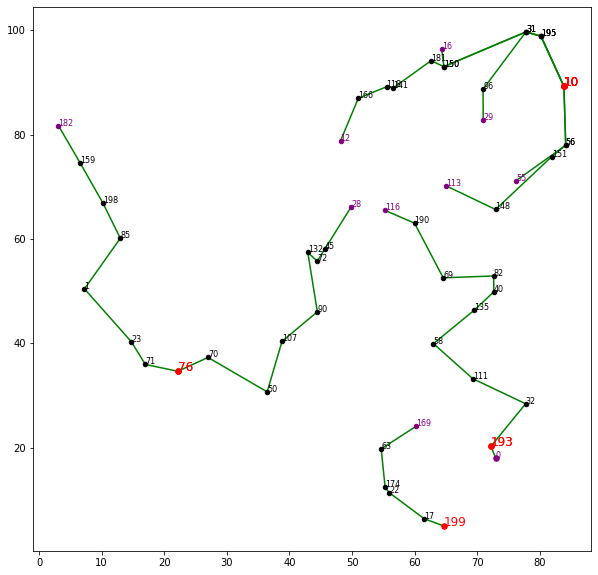

In [52]:
plt.figure(figsize=(10,10))
routes = {x:{} for x in veiculos.index}  
#Cria novamente as rotas de cada veículo
for i in _Solution:
        aux = i.split("_")[1:]
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        
atendimentos = {}
arc_count = {}
for k in veiculos.index:
    #Só roda o código se o veículo tiver percorrido pelo menos um arco
    if len(routes[k]) > 0:
        
        inicial = veiculos.loc[k]["Inicial"]
        actual_node = routes[k].pop(inicial)
        
        #Coordenadas X e Y dos pontos que formam o arco
        xcoord=[pontos.loc[inicial]["x"],pontos.loc[actual_node]["x"]]
        ycoord=[pontos.loc[inicial]["y"],pontos.loc[actual_node]["y"]]
        
        #Plotagem gráfica do arco 
        plt.scatter(xcoord[0],ycoord[0],s=30,color='red',zorder=1)
        plt.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="red")
        plt.plot(xcoord,ycoord,'g',zorder=0)
        
        #String para plotar o caminho que o carro percorreu
        string=str(k)+": "+str(inicial)+" -> "+str(actual_node)
        
        #Garante que o caminho será plotado mesmo se só tiver um arco
        if len(routes[k]) == 0:
            #Plotagem gráfica do último arco do caminho
            plt.scatter(xcoord[1],ycoord[1],s=30,color='purple',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(actual_node),fontsize=8,color="purple")
        else:
            while actual_node not in vitimas["Ponto"].values:
                next_node = routes[k].pop(actual_node)

                #Adiciona um arco na string
                string+="-> "+str(next_node)

                #Coordenadas X e Y dos pontos que formam o arco
                xcoord=[pontos.loc[actual_node]["x"],pontos.loc[next_node]["x"]]
                ycoord=[pontos.loc[actual_node]["y"],pontos.loc[next_node]["y"]]
                
                #Plotagem gráfica do arco 
                plt.scatter(xcoord[0],ycoord[0],s=20,color='black',zorder=1)
                plt.text(xcoord[0],ycoord[0],str(actual_node),fontsize=8)
                plt.plot(xcoord,ycoord,'g',zorder=0)
                
                actual_node=next_node
            
            #Plotagem gráfica do último arco do caminho
            plt.scatter(xcoord[1],ycoord[1],s=20,color='purple',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(next_node),fontsize=8,color='purple')
            
        atendimentos[k] = actual_node
        print(string)
        
plt.show()

# Sinais

In [53]:
estado = pd.read_csv("s_200",index_col=0)

In [54]:
sinais = Model("Sinais")

In [55]:
sinal = 0 #Tempo entre as alterações de estado de um sinal
for i in pontos.index:
    for j in pontos.loc[i][2:]:
        #Somamos o tempo de cada arco
        sinal+=_DistanceMatrix.loc[i][int(j)]
sinal = (sinal/(3*len(pontos))) #O tempo de alteração vai ser a média

In [56]:
ordered_routes = mt.DecomposeRoute(_Solution,veiculos,vitimas) #Organiza os caminhos por ambulância

In [57]:
arc_count = mt.makeArcCount(ordered_routes,_DistanceMatrix) #Arcos usados na solução e a quantidade de usos

In [58]:
def buildSets(_DistanceMatrix,rota_k,sinal,prioridade,pontos,estado,arcos_fixos,nodo=0,instante=0,maior_instante=0,sinais_alterados=[],matriz_sinais=[]):
    if nodo == (len(rota_k)-1):
        #Configuração atual de sinais
        config_atual={}
        
        #Soma dos pesos dessa configuração
        peso_rota=0
        
        for i in sinais_alterados:
            arco = i["arco"]         #<-(saida,chegada)
            alterado = i["alterado"] #<-(0,1)
            instante = i["instante"] #<-(t)
            peso = i["peso"]         #<-Wij

            
            #Adiciona (saida,chegada):{0/1,t} na matriz de sinais
            #                    0=Não alterado
            #                    1=Alterado
            #                    t=Instante
            config_atual[arco]=(alterado,instante)
            
            #Adiciona o peso do arco atual ao peso total da rota
            peso_rota+=peso
        
        #Multiplica o peso da rota 
        #pelo instante de chegada na vítima
        peso_rota*=prioridade
            
        #Adiciona a configuração atual de sinais e o peso correspondente
        #à matriz de configurações para a rota atual
        matriz_sinais.append({"sinais":config_atual,"peso":peso_rota})
        
        #Retorna a matriz de sinais, agora
        #com a configuração atual de sinais
        return matriz_sinais,maior_instante
    
    else:
        #Nodo de saída do arco
        saida = rota_k[nodo]
        #Nodo de chegada do arco
        chegada = rota_k[nodo+1]
        
        #Custo básico 
        custo = _DistanceMatrix.loc[saida][chegada]
        
        #Esse trecho pega o índice do nodo de chegada
        #para verificar o estado do arco (saida,chegada)
        index = pontos.loc[saida][2:][pontos.loc[saida][2:] == chegada].index[0]
        base = estado.loc[saida][index]
        
        #Se o estado do sinal for 
        #alterado, pagamos uma 
        #penalidade pelo
        #número de sinais
        #que precisam ser
        #alterados que não
        #estão na rota
        #     |
        #     v
        alfa=(2*sinal)/(prioridade) 
        
        estado1,instante1 = mt.getStateAtMoment(base,custo,sinal,instante)
        #                     {estado1=0, se ligado no instante   }
        #             estado1={estado1=1, se desligado no instante}
        #               |
        #               v                       ------------------
        peso1 = custo+estado1*sinal# <- sinal = {tempo pra o sinal}
        #                                       {mudar de estado  }
        #                                       -------------------
        #
        # Se estado1=0 -> estado1*sinal=sinal, então pagamos o custo de esperar no sinal
        # Se estado1=1 -> estado1*sinal=0, o sinal está verde e não precisamos esperar
        
        estado2,instante2 = mt.getStateAtMoment(base,custo+sinal,sinal,instante)
        #                                ----------------------
        #                                {Negação do estado2  }
        #                    (1-estado2)={Se estado2=0, vira 1}
        #                         |      {Se estado2=1, vira 0}
        #                         |       ---------------------
        #                         v                        ------------------
        peso2 = custo+alfa+(1-estado2)*sinal # <- sinal = {tempo pra o sinal}
        #               ^                                 {mudar de estado  }
        #               |    -----------------            ------------------
        #             alfa = {Penalidade por }            
        #                    {alterar o sinal}
        #                    ----------------
        # Se (1-estado2)=1 -> (1-estado2)*sinal=0, então pagamos o custo de esperar no sinal
        # Se (1-estado2)=0 -> (1-estado2)*sinal=sinal, o sinal está verde e não precisamos esperar
        
        if len(sinais_alterados) == 0:
            sinais1=[{"arco":(saida,chegada),"alterado":0,"peso":peso1,"instante":instante1}]
            sinais2=[{"arco":(saida,chegada),"alterado":1,"peso":peso2,"instante":instante2}]
        else:

            sinais1 = sinais_alterados.copy()
            sinais2 = sinais_alterados.copy()
            
            sinais1.append({"arco":(saida,chegada),"alterado":0,"peso":peso1,"instante":instante1})
            sinais2.append({"arco":(saida,chegada),"alterado":1,"peso":peso2,"instante":instante2})
            
        #Esse trecho vai garantir que
        #a gente vai receber no final
        #o maior instante, necessário
        #para criarmos a matriz de de-
        #cisão do mesmo tamanho.
        if instante1 > maior_instante:
            maior_instante = instante1
            
        elif instante2 > maior_instante:
            maior_instante=instante2
        
        
        #A intenção desse programa é popular
        #primeiro por profundidade, os ramos
        #à esquerda são ramos onde a alteração
        #do sinal é 0, e à direita 1
        if (saida,chegada not in arcos_fixos):
            #Cairá nessa alternativa quando o arco não
            #tiver sido fixado anteriormente numa 
            #solução do modelo de Sinais
            matriz_sinais, maior_instante = buildSets(_DistanceMatrix,rota_k,sinal,prioridade,pontos,estado,{},nodo+1,instante1,maior_instante,sinais1,matriz_sinais)
            # Comportamento esperado:
            #                       
            #               o
            #              / \
            #             o aberto
            #            / \
            # Entrando<-x  aberto
            #          /
            #        ...
            # matriz_sinais->matriz_sinais + configuração 1

            matriz_sinais, maior_instante = buildSets(_DistanceMatrix,rota_k,sinal,prioridade,pontos,estado,{},nodo+1,instante2,maior_instante,sinais2,matriz_sinais)
            # Comportamento esperado:
            #            o
            #           / \
            #          o
            #         / \
            # Saiu <-v  x->Entrando
            #       /
            #     ...
            # matriz_sinais->matriz_sinais + configuração 1 + configuração 2
        elif arcos_fixos[(saida,chegada)]["alterado"] == 0 and arcos_fixos[(saida,chegada)]["instante"]==instante1:
            #Cairá nessa alternativa quando o
            #arco tiver sido usado, mas não
            #alterado, em uma das soluções
            #do modelo de Sinais
            matriz_sinais, maior_instante = buildSets(_DistanceMatrix,rota_k,sinal,prioridade,pontos,estado,{},nodo+1,instante1,maior_instante,sinais1,matriz_sinais)
            # Comportamento esperado:
            #                       
            #               o
            #              / \
            #             o aberto
            #            / \
            # Entrando<-x  aberto
            #          /
            #        ...
            # matriz_sinais->matriz_sinais + configuração 1
        elif arcos_fixos[(saida,chegada)]["alterado"] == 1 and arcos_fixos[(saida,chegada)]["instante"]==instante2:
            #Cairá nessa alternativa quando o
            #arco tiver sido usado e tiver
            #sido alterado, em uma das 
            #soluções do modelo de Sinais
            matriz_sinais, maior_instante = buildSets(_DistanceMatrix,rota_k,sinal,prioridade,pontos,estado,{},nodo+1,instante2,maior_instante,sinais2,matriz_sinais)
            # Comportamento esperado:
            #            o
            #           / \
            #          o
            #         / \
            # Saiu <-v  x->Entrando
            #       /
            #     ...
            # matriz_sinais->matriz_sinais + configuração 1 + configuração 2
        else:
            #Cairá nessa alternativa quando o
            #arco tiver sido usado, sendo alterado
            #ou não, em uma das soluções do modelo
            #de sinais, porém em um instante diferente
            #da alteração naquele respectivo modelo
            matriz_sinais, maior_instante = buildSets(_DistanceMatrix,rota_k,sinal,prioridade,pontos,estado,{},nodo+1,instante1,maior_instante,sinais1,matriz_sinais)
            # Comportamento esperado:
            #                       
            #               o
            #              / \
            #             o aberto
            #            / \
            # Entrando<-x  aberto
            #          /
            #        ...
            # matriz_sinais->matriz_sinais + configuração 1

            matriz_sinais, maior_instante = buildSets(_DistanceMatrix,rota_k,sinal,prioridade,pontos,estado,{},nodo+1,instante2,maior_instante,sinais2,matriz_sinais)
            # Comportamento esperado:
            #            o
            #           / \
            #          o
            #         / \
            # Saiu <-v  x->Entrando
            #       /
            #     ...
            # matriz_sinais->matriz_sinais + configuração 1 + configuração 2
        return matriz_sinais,maior_instante

In [59]:
#Maior Instante em todos os cenários
#Usado para criar apenas a quantidade
#necessária de variáveis sem desperdiçar memória
maior_instante = 0

#Matriz contendo todas as configurações
#de sinais para cada veículo e sua rota
matriz_rotas={k:[] for k in atendimentos}


for k in atendimentos:
    #
    #
    #                                        Nodo da 
    #                         Nodos de        vítima        pd.Series
    #           Prioridade    todas as       atendida    com a prioridade
    #            em si        vítimas         por 'k'       da vítima
    #             |              |              |              | 
    #             v              v              v              v           
    prioridade=vitimas[vitimas["Ponto"]==atendimentos[k]]["Prioridade"].values[0]
    
    matriz,instante=  buildSets(_DistanceMatrix,    #Matriz de Distância
                                 ordered_routes[k],  #Rotas por veículo
                                 sinal,              #Tempo de alteração do sinal
                                 prioridade,         #Prioridade da vítima atendida por 'k'
                                 pontos,             #DataFrame com os pontos e arcos
                                 estado,             #DataFrame com os estados dos sinais
                                 arcos_fixos={},     #Arcos já fixados anteriormente
                                 sinais_alterados=[],#Uso interno, instanciar como lista vazia
                                 matriz_sinais=[])   #Uso interno, instanciar como lista vazia
    #Guarda o maior instante
    #encontrado até o momento
    if instante>maior_instante:
        maior_instante=instante
    
    #Adiciona as configurações
    #possíveis para a rota do
    #veículo 'k' para a matriz
    matriz_rotas[k] = matriz

In [60]:
#Dicionário para guardar os
#veículos que passam no mesmo
#arco no mesmo instante
same_instant={}

for arc in arc_count:
    #Adiciona o arco atual
    #no dicionário
    same_instant[arc]={}
    
    #Dicionário de instantes
    #separado por veículo
    instants={}
    for k in atendimentos:
        #                         Índice
        #                     da configuração
        #                           |
        #                           | Arcos percorridos
        # (x,y)             Veículo |       por 'k'
        #   |                  |    /   _____|______
        #   v                  v   v   |            |
        if arc in matriz_rotas[k][0]["sinais"].keys():#'k' passa em (x,y)?
            #Contador do índice das
            #configurações dos sinais
            count = 0
            
            #Variedade de instantes
            #em que 'k' pode passar
            #em (x,y) de acordo com
            #a configuração que o 
            #modelo escolher
            instants[arc]=[]
            
            #Percorre todas as configurações
            #de sinais para a rota de 'k'
            while count < len(matriz_rotas[k]):
                #                         Índice da           Instante
                #                        Configuração             |
                #                             |  Configuração     |
                #                     Veículo |       |     (x,y) |
                #                        |    |       |       |   |
                #                        v    v       v       v   v
                instant_k = matriz_rotas[k][count]["sinais"][arc][1]#Quando 'k' passa em (x,y)?

                #Verificamos se o instante atual ainda não
                #está listado nos instantes em que um dos
                #veículos passa em (x,y)
                if round(instant_k) not in instants[arc]:
                    
                    #Quando for a primeira vez que um veículo
                    #passa em (x,y), adicionamos esse instante
                    #na lista
                    instants[arc].append(round(instant_k))
                    
                    #Quando for a primeira vez que um veículo
                    #passa em (x,y) nesse instante, criamos a
                    #lista no nosso dicionário, usamos o instante
                    #arredondado para baixo como chave e uma tupla
                    #(Veículo,ìndice da Configuração) como valor
                    same_instant[arc][round(instant_k)]=[(k,count)]
                    
                else:
                    #Quando uma nova configuração for encontrada na qual
                    #um veículo passe em (x,y) no mesmo instante, adicionamos
                    #a tupla (Veículo,ìndice da Configuração) no dicionário
                    same_instant[arc][round(instant_k)].append((k,count))
                    #NOTA IMPORTANTE:
                    #
                    #Arredondamos o instante para o inteiro
                    #mais próximo para evitar inconsistências.
                    #Uma vez que se ambos estiverem no arco durante
                    #o mesmo intervalo, os dois se beneficiarão da
                    #alteração ou não alteração do sinal.
                    #
                    #Por exemplo:
                    #   Veículo1 está em (x,y) no instante 7.2
                    #   Veículo2 está em (x,y) no instante 7.31
                    #
                    #      7.2                     7.31
                    #   instante_k Veículo1 != instante_k Veículo2
                    #
                    #           7                           7
                    #    _______|______              _______|______
                    #   |              |            |              |   
                    #   round(instant_k) Veículo == round(instant_k) Veículo2
                count+=1

In [61]:
#Dicionário onde guardaremos
#todas as variáveis do modelo
config = {}

#Nos preocupamos apenas com os
#veículos que saíram para realizar 
#algum atendimento
for k in atendimentos:
    
    #Contador do índice
    #das configurações
    count=0
    
    #Lista das possíveis configurações
    #de sinais para o veículo 'k'
    config[k]=[]
    
    for i in matriz_rotas[k]:
        #                                                         Índice           Veículo    Peso da Configuração
        #                                                           |                 |                | 
        #                                                           v                 v                v 
        config[k].append({"Config":sinais.binary_var("Config_"+str(count)+"_Carro_"+str(k)),"Peso":i["peso"]})
        #"Config":Variável de Decisão que representa uma configuração completa
        #"Peso": Tempo de percorrer a rota com essa configuração de sinais
        count+=1

In [62]:
#Função Objetivo
minimize=LinearExpr(sinais)

for k in atendimentos:
    #Restrição de unicidade
    choose1=LinearExpr(sinais)
    
    for i in config[k]:
        #Adiciona a configuração 
        #atual à restrição
        choose1+=i["Config"]
        
        #Adiciona o peso da configuração
        #na função objetivida para ser
        #minimizado futuramente
        minimize+=i["Config"]*i["Peso"]
        
    #Permitimos ao modelo escolher
    #apenas uma configuração para
    #cada rota percorrida
    sinais.add_constraint(choose1==1,"Choose1ConfigVehicle"+str(k))
    
sinais.minimize(minimize)

In [63]:
#Varremos todos os arcos
#no nosso dicionário
for arc in same_instant:
    
    #Precisamos verificar todos os
    #instantes em que um veículo
    #passou por esse arco
    for instant in same_instant[arc]:
        
        #Dicionário que irá conter
        #todas as expressões de
        #consistência que iremos criar
        expressions={}
        
        for i in same_instant[arc][instant]:
            #i=(Veículo,Índice da Configuração)
            vehicle = i[0]
            config_number = i[1]
            
            #Verificamos se o veículo atual
            #não está entre as chaves do nosso
            #dicionário de expressões
            if vehicle not in expressions.keys():
                #Criamos a expressão linear
                #que será usada como restrição
                expr=LinearExpr(sinais)
                
                #Inicializamos ela com a configuração atual
                expr+=config[vehicle][config_number]["Config"]
                
                #Instanciamos a chave no dicionário
                expressions[vehicle]=expr
            else:
                #Adicionaremos todas as configurações
                #do veículo 'k' que passam em (x,y)
                #no mesmo instante
                expressions[vehicle]+=config[vehicle][config_number]["Config"]
        
        #Restrição de Consistência
        consistent_timing=LinearExpr(sinais)
        #Contador Auxiliar
        count=0
        for k in expressions:
            #Consideramos o primeiro veículo como o pivô
            if count==0:
                #Todas as configurações dele são multiplicadas
                #pela quantidade de OUTROS veículos no dicionário
                consistent_timing+=(len(expressions)-1)*expressions[k]
                count+=1
            else:
                #Caso não seja nosso veículo pivô, subtraímos
                #a configuração da nossa expressão
                consistent_timing-=expressions[k]
        
        #A expressão é construída dessa forma pois,
        #caso alguma das configurações seja escolhida,
        #nós forçamos que todas as outras também o sejam
        #e, caso nenhuma seja escolhida, que nenhuma das
        #outras também o seja
        #Exemplo:
        #    k=Veículo Pivô a=b= Outros Veículos
        #   
        #    expr=2*k_0 + 2*k_1...+2*k_m 
        #         - a_0 - a_1 -...a_n
        #         - b_0 - b_1 -...b_o
        #
        #    Se k_0 = 1 e expr==0, Então:           _
        #         - a_0 - a_1 -...a_n = -1 |-Só pode escolher 
        #         - b_0 - b_1 -...b_o = -1_| uma configuração
        #
        #    Se 2*k_0 + 2*k_1...+2*k_m = 0 e expr == 0, Então
        #         - a_0 - a_1 -...a_n = 0
        #         - b_0 - b_1 -...b_o = 0
        sinais.add_constraint(consistent_timing==0,"ConsistentTimingArc_"+str(arc)+"_instant_"+str(instant))

In [64]:
_Solution2 = sinais.solve()

In [65]:
#Sinais Fixados
sinais_fixos={}

#Instantes de chegada
#na vitimas atendinda
atendimento_instantes={}

#O código abaixo serve apenas para imprimir
#a solução em uma espécie de texto formatado
#e fixar os sinais da solução atual
for i in _Solution2.as_dict():
    carro = int(i.split("_")[3])
    config = int(i.split("_")[1])
    string1="Veículo"+str(carro)
    string2="(Sit,T)"+" "*(len(string1)-4)
    for i in matriz_rotas[int(carro)][int(config)]["sinais"]:
        string1+= "-> "+str(i)
        
        alterado=matriz_rotas[carro][config]["sinais"][i][0]
        instante=round(matriz_rotas[carro][config]["sinais"][i][1])
        string2+=str((alterado,instante))+" "*(len(str(i))-3)
        sinais_fixos[i]={"alterado":alterado,"instante":instante}
    atendimento_instantes[carro]=instante
    print(string1)
    print(string2)
    print("")

Veículo0-> (193, 0)
(Sit,T)    (0, 0)     

Veículo3-> (76, 71)-> (71, 23)-> (23, 1)-> (1, 85)-> (85, 198)-> (198, 159)-> (159, 182)
(Sit,T)    (0, 1)     (0, 1)     (0, 2)    (0, 4)    (1, 5)      (1, 7)       (1, 9)       

Veículo4-> (10, 195)-> (195, 31)-> (31, 150)-> (150, 16)
(Sit,T)    (0, 1)      (0, 1)      (0, 3)      (0, 3)      

Veículo6-> (10, 195)-> (195, 31)-> (31, 96)-> (96, 29)
(Sit,T)    (0, 1)      (0, 1)      (0, 3)     (0, 3)     

Veículo8-> (10, 195)-> (195, 31)-> (31, 150)-> (150, 181)-> (181, 141)-> (141, 118)-> (118, 166)-> (166, 12)
(Sit,T)    (0, 1)      (0, 1)      (0, 3)      (0, 3)       (0, 4)       (0, 4)       (1, 6)       (0, 6)      

Veículo17-> (199, 17)-> (17, 22)-> (22, 174)-> (174, 63)-> (63, 169)
(Sit,T)     (0, 0)      (1, 2)     (0, 2)      (0, 3)      (0, 4)      

Veículo18-> (10, 56)-> (56, 55)
(Sit,T)     (0, 1)     (0, 2)     

Veículo20-> (193, 32)-> (32, 111)-> (111, 58)-> (58, 135)-> (135, 40)-> (40, 82)-> (82, 69)-> (69, 190)-> (190

# VRP - Volta

In [66]:
vrp_volta = Model("Ambulancias-VRP") #Modelo

In [67]:
#Matriz com as variáveis de decisão principais
#Desta vez nos preocupamos apenas com os veículos
#que atenderam algum paciente
_DecisionCube = vrp_volta.binary_var_cube(_DistanceMatrix.index,_DistanceMatrix.index,atendimentos,"Arc")

In [68]:
#Função Objetivo
vrp_volta.minimize(vrp_volta.sum(_DecisionCube[i,j,k]*_DistanceMatrix.loc[i][j] 
                     for i in _DistanceMatrix.index 
                     for j in _DistanceMatrix.index 
                     for k in atendimentos))

In [69]:
alvos = {k:0 for k in atendimentos}

In [70]:
for k in atendimentos:
    alvos[k] = hospitais[np.random.randint(0,len(hospitais))]

In [71]:
forbidden = LinearExpr(vrp_volta)   #Arcos proíbidos

for k in atendimentos:
    for i in _DistanceMatrix.index:

        flux = LinearExpr(vrp_volta)    #Conservação de Fluxo
        for j in _DistanceMatrix.index:

            if _DistanceMatrix.loc[i][j] > 0:    #Verifica se o arco existe

                if i == alvos[k]:                  #Se nodo 'i' for uma vítima:
                    flux +=_DecisionCube[j,i,k]    #Subtrai o arco de chegada em 'i'
                    forbidden+=_DecisionCube[i,j,k]#A ambulância não pode um arco saindo de 'i'

                elif i == atendimentos[k]:            #Se o nodo 'i' for um hospital
                    flux += _DecisionCube[i,j,k]      #Adiciona o arco de saída de 'i'

                elif j == atendimentos[k]:            #Se o nodo 'j' for o ponto de saida de 'k'
                    flux -=_DecisionCube[j,i,k]
                    forbidden += _DecisionCube[i,j,k] #Retira o arco 'ij' da solução

                else:                                 #Se nenhum desses casos se aplicar
                    flux+=_DecisionCube[i,j,k]-_DecisionCube[j,i,k] #Fluxo normal
            else:                                #Se o arco não existir
                forbidden += _DecisionCube[i,j,k]#Tira ele da solução
        if i == alvos[k]: #Se nodo 'i' for uma vítima
            #Permite 'k' chegar em 'i' no máximo 1 vez
            vrp_volta.add_constraint(flux==1,"ChegadaVitima_"+str(i)+"_Carro_"+str(k))

        elif i == atendimentos[k]: #Se o nodo 'i' for o inicial do veiculo 'k'
                                    #Permite 'k' sair de 'i' no máximo 1 vez
            vrp_volta.add_constraint(flux==1,"FluxoInicialVeiculo_"+str(k))
        else:
            #Fluxo Normal
            vrp_volta.add_constraint(flux==0,"Fluxo_"+str(i)+"_Carro_"+str(k))

#Eliminação dos arcos inválidos
vrp_volta.add_constraint(forbidden==0,"Cuts");

In [72]:
vrp_volta.export_as_lp("VRPVOLTA")

'VRPVOLTA.lp'

In [73]:
import time
start = time.time() #Tempo de ínicio
subcicle = True     #Condição de parada
#Assumindo que existe subciclos, nós...
while subcicle == True:

    #Rota percorrida por cada veículo
    routes = {k:{} for k in atendimentos}    

    #Solução vrp_volta - Dicionário Desordenado
    _Solution = vrp_volta.solve(log_output=True).as_dict()
    #saida veículo
    #    |   |
    #    v   v
    #Arc_i_j_k: True/False <-Valores Possíveis
    #      ^
    #      |
    #   chegada
    #
    #Arc_i_j_k = Chave

    for i in _Solution:
        #
        #
        #"Arc_i_j_k"
        #     |   
        #     v                      0   1   2
        aux = i.split("_")[1:] #<- ["i","j","k"]
        #        ^
        #        |
        #["Arc","i","j","k"]
        #
        #         veiculo=k    saida=i      chegada=j
        #             |            |            |
        #             v            v            v
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        # ^
        # |_ Rotas agrupadas por veículo

    print(routes)
    count = 0 #Contador para as eliminações de subciclo
    summ = 0 #Condição de parada

    #O trecho de código abaixo deve remover o caminho
    #principal para futuramente verificarmos se existe
    #algum subciclo na rota do veículo 'k'
    for k in atendimentos:

        #Primeiramente, verificamos se o veículo 'k'
        #percorreu, ou não, pelo menos um arco
        if len(routes[k]) > 0:

            #Se ele percorreu pelo menos um arco:
            #Começamos verificando qual o ponto de saida
            #do veículo 'k' e atribuímos esse nodo para
            #o ponto de partida do nosso loop

            inicial = atendimentos[k]
            #  ^
            #  |
            #Saída de 'k'
            #
            #Chegada de 'k'
            #saindo do ponto
            #inicial
            #  |
            #  v
            actual_node = routes[k].pop(inicial)

            #inicial->actual_node = primeiro arco de todas as rotas

            #Iremos percorrer a rota até que alcançemos a vítima
            while actual_node != alvos[k]:
                # actual_node                actual_node
                #vira chegada do        inicia como saída do
                #  arco                        arco
                #   |                            |
                #   v                            v
                actual_node = routes[k].pop(actual_node)

                #it0: actual_node-> nodo 'j'
                #               ^
                #               |
                #it1:     actual_node -> nodo 'k'
                #                             ^
                #                             |
                #it2:                     actual_node -> nodo 'l' ...


        #Se sobrou algum subciclo
        #depois da remoção do caminho
        #principal então 
        #len(routes[k]) > 0
        summ += len(routes[k])


        #Se sobrou algum arco dentro
        #da rota, então deve ser algum
        #subciclo que devemos retirar
        if len(routes[k]) >0:

            #Enquanto ainda existir algum arco
            #dentro da rota do veículo 'k'
            #ele faz parte de um subciclo
            #que deve ser retirado, portanto
            #iteramos até removermos todos os
            #subciclos
            while(len(routes[k])>0):
                print(routes[k])
                cut = LinearExpr(vrp_volta) #Expressão Linear do Subciclo atual

                first_node = list(routes[k].keys())[0]
                #  ^
                #  |
                #saída do primeiro arco
                #do subciclo atual
                #
                #chegada do primeiro
                #arco do subciclo atual
                #  |
                #  v
                actual_node = routes[k].pop(first_node)

                #Adicionamos o arco inicial à restrição
                cut += _DecisionCube[int(first_node),int(actual_node),k]

                #Tamanho do subciclo -1
                size = 0
                while(actual_node != first_node):
                    next_node = routes[k].pop(actual_node)                 #Percorre o subciclo e o adiciona ao#
                    cut += _DecisionCube[int(actual_node),int(next_node),k]#conjunto de subciclos proíbidos.#
                    actual_node = next_node
                    size+=1
                count+=1
                vrp_volta.add_constraint(cut<=size,"SubCycleCut_"+str(count))

    if summ == 0:
        subcicle = False
print(time.time()-start)


Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 392080 columns.
Reduced MIP has 2000 rows, 7920 columns, and 15840 nonzeros.
Reduced MIP has 7920 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.28 sec. (131.69 ticks)
Found incumbent of value 26080.869942 after 0.52 sec. (204.78 ticks)
Probing time = 0.05 sec. (0.51 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 2000 rows, 7920 columns, and 15840 nonzeros.
Reduced MIP has 7920 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (9.55 ticks)
Probing time = 0.01 sec. (0.60 ticks)
Clique table members: 20.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.05 sec. (11.24 ticks)

      

0: 0 -> 138-> 32-> 111-> 101-> 177-> 175-> 36-> 76
3: 182 -> 159-> 198-> 85-> 1-> 23-> 71-> 76
4: 16 -> 181-> 141-> 118-> 166-> 98-> 33-> 189-> 192-> 49-> 187-> 8-> 167-> 137-> 70-> 76
6: 29 -> 196-> 113-> 190-> 69-> 82-> 40-> 135-> 58-> 111-> 32-> 193
8: 12 -> 166-> 118-> 139-> 191-> 193
17: 169 -> 177-> 101-> 111-> 32-> 193
18: 55 -> 151-> 130-> 121-> 47-> 102-> 93-> 140-> 32-> 193
20: 116 -> 190-> 69-> 82-> 40-> 135-> 58-> 111-> 32-> 193
22: 28 -> 45-> 72-> 132-> 90-> 117-> 68-> 129-> 128-> 63-> 174-> 22-> 17-> 199
27: 113 -> 190-> 69-> 82-> 40-> 135-> 58-> 111-> 32-> 193


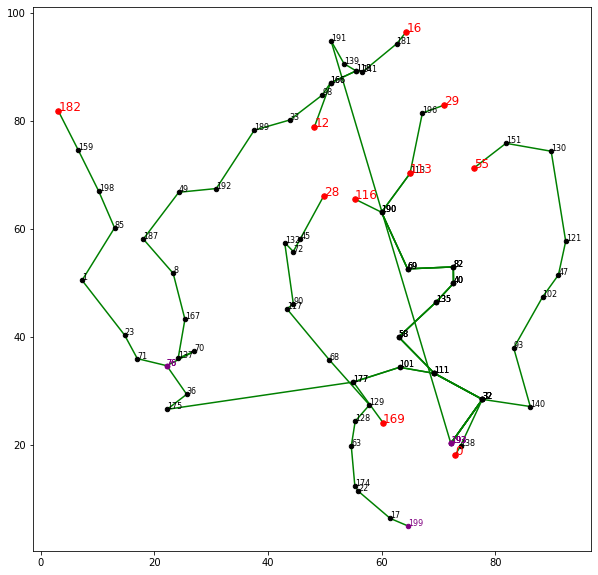

In [74]:
plt.figure(figsize=(10,10))
routes = {x:{} for x in veiculos.index}  
#Cria novamente as rotas de cada veículo
for i in _Solution:
        aux = i.split("_")[1:]
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        
arc_count = {}
for k in atendimentos:
    #Só roda o código se o veículo tiver percorrido pelo menos um arco
    if len(routes[k]) > 0:
        
        inicial = atendimentos[k]
        actual_node = routes[k].pop(inicial)
        
        #Coordenadas X e Y dos pontos que formam o arco
        xcoord=[pontos.loc[inicial]["x"],pontos.loc[actual_node]["x"]]
        ycoord=[pontos.loc[inicial]["y"],pontos.loc[actual_node]["y"]]
        
        #Plotagem gráfica do arco 
        plt.scatter(xcoord[0],ycoord[0],s=30,color='red',zorder=1)
        plt.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="red")
        plt.plot(xcoord,ycoord,'g',zorder=0)
        
        #String para plotar o caminho que o carro percorreu
        string=str(k)+": "+str(inicial)+" -> "+str(actual_node)
        
        #Garante que o caminho será plotado mesmo se só tiver um arco
        if len(routes[k]) == 0:
            #Plotagem gráfica do último arco do caminho
            plt.scatter(xcoord[1],ycoord[1],s=30,color='purple',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(actual_node),fontsize=8,color="purple")
        else:
            while actual_node != alvos[k]:
                next_node = routes[k].pop(actual_node)

                #Adiciona um arco na string
                string+="-> "+str(next_node)

                #Coordenadas X e Y dos pontos que formam o arco
                xcoord=[pontos.loc[actual_node]["x"],pontos.loc[next_node]["x"]]
                ycoord=[pontos.loc[actual_node]["y"],pontos.loc[next_node]["y"]]
                
                #Plotagem gráfica do arco 
                plt.scatter(xcoord[0],ycoord[0],s=20,color='black',zorder=1)
                plt.text(xcoord[0],ycoord[0],str(actual_node),fontsize=8)
                plt.plot(xcoord,ycoord,'g',zorder=0)
                
                actual_node=next_node
            
            #Plotagem gráfica do último arco do caminho
            plt.scatter(xcoord[1],ycoord[1],s=20,color='purple',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(next_node),fontsize=8,color='purple')
            
        atendimentos[k] = actual_node
        print(string)
        
plt.show()

In [79]:
for k in atendimento_instantes

{0: 0, 3: 9, 4: 3, 6: 3, 8: 6, 17: 4, 18: 2, 20: 9, 22: 9, 27: 5}